## Compressed sensing with QFT

**Compressed sensing objective**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D}$ we want to find a vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } C\mathbf{x} = CF^{-1}\mathbf{s}
$$


**Tensorized extension of compressed sensing**

Given a high dimensional signal $\mathbf{x} \in\mathbb{R}^{D\times\cdots\times D}$ represented in TT format with ranks $\{R_i\}_{i=1}^N$ we want to find a TT-vector $\mathbf{s}^*$ in the set. 

$$
\argmin_{\mathbf{s} \in \mathbb{R}^{D}}  \|\mathbf{s}\|_1  \\
\text{s.t. } \mathcal{C}\mathcal{x} = \mathcal{C}\mathcal{F}^{-1}\mathcal{s}
$$

where $\mathcal{C}\,\&\,\mathcal{F}$ are Matrix Product Operators (MPO).


### Constrained optimization

In [ ]:
# Install packages
!pip install quimb 

In [7]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from scipy.optimize import minimize
from math import sqrt

# =======================================================
# (Example 1) Standard Constrained Optimization in NumPy
# =======================================================

# def f(x):
#     print(x)
#     return sqrt(0.1*x[0]*x[1])

# def ineq_constraint(x):
#     return x[0] - x[1]

# con = {'type': 'ineq', 'fun': ineq_constraint}

# x0 = [1, 1]
# res = minimize(f, x0, method='SLSQP', constraints=con, bounds=[(0, None) for i in range(len(x0))], options={'disp': True, 'iprint': 2})


# ===============================================
# (Example 2) Simple MPS constrained optimization
# ===============================================

# def f(x, H, R, D, verbose=False):
#     # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
#     x = x.reshape(H, R, R, D)

#     # Each MPS core is of shape (Rl, Rr, D)
#     arrays = [x[0][0:1, ...]] + [x[i] for i in range(1, H-1)] + [x[H-1][..., 0:1, :]]
#     if verbose:
#         print('\n'.join(str(a.shape) for a in arrays))

#     # Create the MPS
#     mps = qtn.MatrixProductState(arrays)
#     return mps.norm()


# H, R, D = 8, 2, 2
# con = [{'type': 'ineq', 'fun': lambda x, idx=i: (x[idx] - 0.5)} for i in range(H*R*R*D)]

# x0 = np.random.rand(H*R*R*D)
# res = minimize(f, x0, method='SLSQP', constraints=con, args=(H, R, D), options={'disp': True, 'iprint': 2})


# ================================================
# (Main) MPS compressed sensing (Example 3)
# ================================================

def obj_fn(x, L, R, D, verbose=False):
    # x represents a D^H tensor via a TT-vector. Shape: (H*R^2*D)
    x = x.reshape(L, R, R, D)
    x_mps = vec2mps(x, L, R, D)
    return x_mps.norm()  # should make l1 norm

def vec2mps(x, L, R, D) -> qtn.MatrixProductState:
     x = x.reshape(L, R, R, D)
     return qtn.MatrixProductState([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :]])

def vec2mpo(x, L, R, D) -> qtn.MatrixProductOperator:
     x = x.reshape(L, R, R, D, D)
     return qtn.MatrixProductOperator([x[0][0:1, ...]] + [x[i] for i in range(1, L-1)] + [x[L-1][..., 0:1, :, :]])


L, R, D = 8, 2, 4

# Create MPO transforms
c = np.random.rand(L, R, R, D, D)  # sampler MPO
finv = np.random.rand(L, R, R, D, D)  # inverse fourier MPO
c_mpo = qtn.MatrixProductOperator([c[0][0:1, ...]] + [c[i] for i in range(1, L-1)] + [c[L-1][..., 0:1, :, :]])
finv_mpo = qtn.MatrixProductOperator([finv[0][0:1, ...]] + [finv[i] for i in range(1, L-1)] + [finv[L-1][..., 0:1, :, :]])
w_mpo = c_mpo.apply(finv_mpo)  # combined MPO


# Original signal
x_targ_mps = qtn.MPS_rand_state(L=L, bond_dim=R, phys_dim=D)  # dense tensor
y_mps = c_mpo.apply(x_targ_mps)

con = []
# i.e. y - CFs = 0
con.append({'type': 'eq', 'fun': lambda s_t: (w_mpo.apply(vec2mps(s_t, L, R, D)) - y_mps).norm()})

x0 = np.random.rand(L*R*R*D)
res = minimize(obj_fn, x0, method='SLSQP', constraints=con, args=(L, R, D), options={'disp': True, 'iprint': 2})

  NIT    FC           OBJFUN            GNORM
    1   130     5.750997E+10     2.693384E+02
    2   261     2.657291E+05     2.150438E+02
    3   392     6.523824E+03     2.093686E+02
    4   522     6.971943E+03     1.970488E+02
    5   652     4.275163E+09     1.804037E+02
    6   783     3.435327E+06     1.846679E+02
    7   913     3.178742E+07     2.132773E+02
    8  1045     5.473043E+10     2.121769E+02
    9  1177     5.049110E+13     2.702926E+02
   10  1309     1.991316E+16     3.112463E+02
   11  1442     4.339439E+09     3.637591E+02
   12  1573     7.850922E+10     4.811807E+02
   13  1705     9.212569E+07     4.802707E+02
   14  1836     6.248081E+09     2.660805E+02
   15  1967     4.597640E+11     2.641672E+02
   16  2099     1.227795E+06     2.463116E+02
   17  2230     2.198992E+08     1.738935E+02
   18  2361     2.419083E+10     1.240734E+02
   19  2493     7.663578E+10     1.413877E+02
   20  2625     7.405568E+05     1.144086E+02
   21  2757     1.371338E+07     9

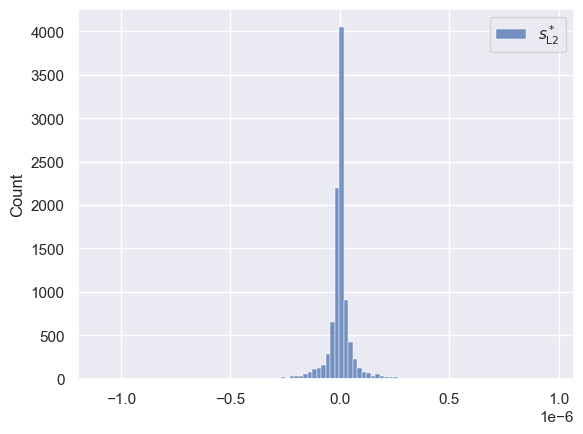

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


def random_samples_with_amplitudes(mps, num_samples=5):
    L = mps.L
    d = mps.phys_dim()
    results = []

    for _ in range(num_samples):
        # uniformly random configuration
        cfg = np.random.randint(0, d, size=L)
        mapping = {mps.site_ind(i): int(cfg[i]) for i in range(L)}

        # contract to get amplitude
        amp = mps.isel(mapping).contract(output_inds=())

        results.append(amp)

    return results


samples_l2 = random_samples_with_amplitudes(vec2mps(res.x, L, R, D), num_samples=10000)
samples_random = random_samples_with_amplitudes(vec2mps(x0, L, R, D), num_samples=10000)
sns.set_theme()
sns.histplot(samples_l2, bins=100, label=r"$s^*_{\mathrm{L2}}$")
# sns.histplot(samples_random, bins=100, label=r"$s_0$")
plt.legend()
plt.show()

### Tensor completion

In [87]:
# ===================================
# Tensor completion (Basic Example)
# ===================================

import tntorch as tn
import torch

# Model
t = tn.rand(32, 32, 32, ranks_tt=6, requires_grad=True)

# Data
X = [[0, 0, 0], [0, 0, 1], [0, 0, 2]]
y = torch.randn(3)

def loss(t):
    return tn.relative_error(y, t[X])
tn.optimize(t, loss)


iter: 0       | loss:  14.309007 | total time:    0.0440
iter: 500     | loss:   1.697409 | total time:    0.3137
iter: 933     | loss:   0.952028 | total time:    0.4992 <- converged (tol=0.0001)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..221.0].


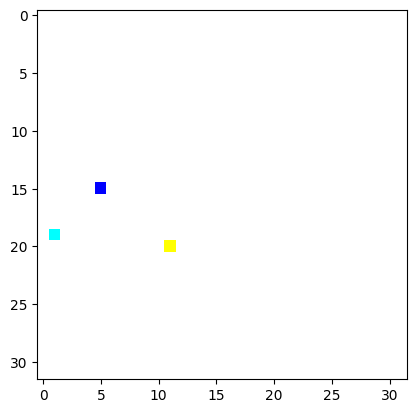

y: torch.Size([307]) | ids_tens: torch.Size([307])
iter: 0       | loss:  76.315300 +   6.929828 =      83.25 | total time:    0.0051
iter: 500     | loss:   3.363400 +   0.571323 =      3.935 | total time:    1.0834
iter: 1000    | loss:   1.164080 +   0.223587 =      1.388 | total time:    2.2125
iter: 1500    | loss:   0.670613 +   0.142000 =     0.8126 | total time:    3.3154
iter: 2000    | loss:   0.449655 +   0.114570 =     0.5642 | total time:    4.3967


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_image(filepath, size=(600, 600), show=False):
    img = Image.open(filepath).convert("RGB")  # ensures 3 channels
    img_resized = img.resize(size, Image.Resampling.LANCZOS)
    x_down = np.asarray(img_resized, dtype=np.float32)
    if show:
        plt.imshow(img_resized)
        plt.show()
    return x_down

# Hyperparameters
# n_samples = 10_000
filepath = "../../data/einstein/einstein.jpg"
height, width = 32, 32
size = (height, width)
n_samples = int(0.1*height*width*3)


# Data
x = torch.tensor(load_image(filepath, size, show=True))
x = (x - x.mean()) / x.std()
ids = torch.randint(0, height*width*3, (n_samples,))
ids_tens = torch.unravel_index(ids, (height, width, 3))
y = x.reshape(-1).gather(0, ids)  # (n_samples,)
print(f"y: {y.shape} | ids_tens: {ids_tens[0].shape}")

# Model
t = tn.rand(height, width, 3, ranks_tt=8, requires_grad=True)

# Loss
def loss(t):
    # return tn.relative_error(y, t[ids_tens]) 
    return tn.relative_error(y, t[ids_tens])**2, tn.normsq(tn.partialset(t, order=2))*1e-4

tn.optimize(t, loss)


In [110]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Hyperparameters
n_samples = int(0.1*600*600*3)
# n_samples = 10_000
filepath = "../../data/einstein/tntorch.jpeg"

# Data
x = torch.tensor(plt.imread(filepath), dtype=torch.float32)
x.shape
# # Standardize
# x = (x - x.mean()) / x.std()
# ids = torch.randint(0, 600*600*3, (n_samples,))
# ids_tens = torch.unravel_index(ids, (600, 600, 3))
# y = x.reshape(-1).gather(0, ids)  # (n_samples,)
# print(f"y: {y.shape} | ids_tens: {ids_tens[0].shape}")

# # Model
# t = tn.rand(600, 600, 3, ranks_tt=8, requires_grad=True)

# # Loss
# def loss(t):
#     # return tn.relative_error(y, t[ids_tens]) 
#     return tn.relative_error(y, t[ids_tens])**2, tn.normsq(tn.partialset(t, order=2))*1e-4

# tn.optimize(t, loss)


torch.Size([149, 372, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17348072..0.27099082].


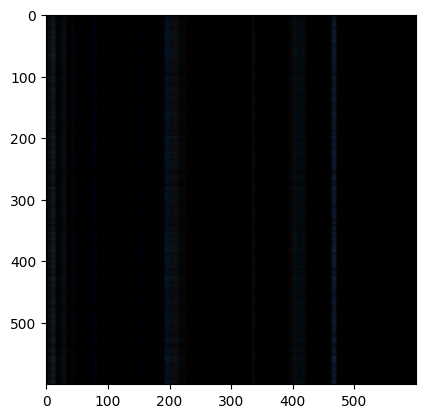

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3608631..5.0279884].


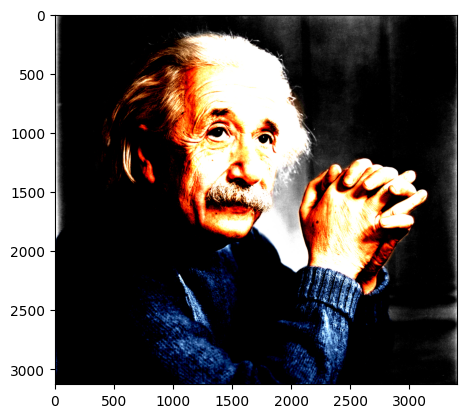

x.min(): -1.36 | x.max(): 5.03 | t.min(): -0.17 | t.max(): 0.27


In [105]:
plt.imshow(t.numpy(), vmin=t.numpy().min(), vmax=t.numpy().max())
plt.show()
# t.numpy()
plt.imshow(x.numpy(), vmin=x.numpy().min(), vmax=x.numpy().max())
plt.show()
print(f"x.min(): {x.numpy().min():.2f} | x.max(): {x.numpy().max():.2f} | t.min(): {t.numpy().min():.2f} | t.max(): {t.numpy().max():.2f}")

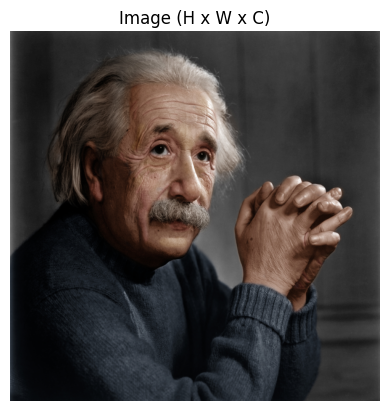

In [4]:
# Plot 2d image
plt.imshow(x_2d)
plt.axis('off')
plt.title("Image (H x W x C)")
plt.show()

In [ ]:
# Hyperparameters
bond_dim = 10
phys_dim = 3
n_samples = int(0.1*600*600*3)


# Create targets
ids = torch.randint(0, 600*600*3, (n_samples,))
x_targ = x.reshape(-1).gather(0, ids)


# Create random MPS
model = qtn.MPS_rand_state(L=6, bond_dim=10, phys_dim=phys_dim)

# Create MPO
C = qtn.MatrixProductOperator.randn(L=6, bond_dim=10, phys_dim=phys_dim, phys_dim_out=phys_dim)

# Create target MPS


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


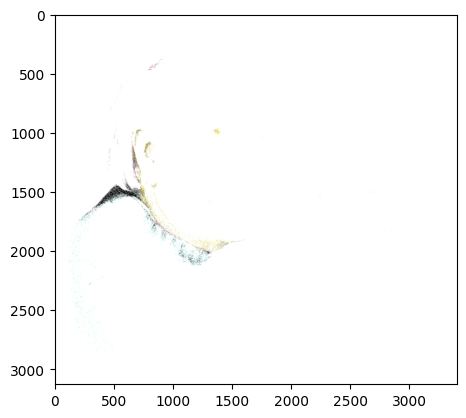

We will keep 1063180 out of 10631800 pixels


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tntorch as tn

im = torch.DoubleTensor(plt.imread('../../data/einstein/einstein.jpg'))
plt.imshow(im, cmap='gray', vmin=im.min(), vmax=im.max())
plt.show()

P = im.shape[0]*im.shape[1]
Q = int(P/10)
print('We will keep {} out of {} pixels'.format(Q, P))
X = np.unravel_index(np.random.choice(P, Q), im.shape)  # Coordinates of surviving pixels
y = torch.Tensor(im[X])  # Grayscale values of surviving pixels

In [60]:
torch.unravel_index(torch.tensor([5]), (3, 3))

(tensor([1]), tensor([2]))